## Pré-processamento

In [246]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
import string
from sklearn.model_selection import train_test_split
#import spacy

df = pd.read_csv('factnews_dataset.csv')

#criar grupo treino e teste
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

stop_words = set(stopwords.words('portuguese'))

#criar coluna tokens
train_df['tokens'] = train_df['sentences'].apply(lambda x: nltk.word_tokenize(str(x).lower()))

# Tokenizar sem stopwords
train_df['tokens'] = train_df['tokens'].apply(lambda toks: [t for t in toks if t not in stop_words])
#tirar exemplos da classe 0 para nivelar
classe0 = train_df[train_df['classe'] == 0]
classe0 = classe0.sample(n=443, random_state=42)
outras_classes = train_df[train_df['classe'] != 0]
train_df = pd.concat([outras_classes, classe0]).reset_index(drop=True)
print(train_df['classe'].value_counts())


classe
-1    969
 0    443
 1    375
Name: count, dtype: int64


## Análise exploratória

Detetar palavras únicas entre as classes

In [247]:
classes = df['classe'].unique()

def palavras_unicas_por_classe(df, token_col):
    
    # contar tokens por classe
    tokens_por_classe = {}
    for classe in classes:
        linhas_classe = df[df['classe'] == classe][token_col].dropna()
        contagem = {}
        for lista in linhas_classe:
            for token in lista:
                if token in contagem:
                    contagem[token] += 1
                else:
                    contagem[token] = 1
        tokens_por_classe[classe] = contagem

    # detetar palavras exclusivas por classe
    palavras_unicas = {}
    for classe in classes:
        # lista de palavras das outras classes
        outras_palavras = []
        for outra_classe in classes:
            if outra_classe != classe:
                for token in tokens_por_classe[outra_classe]:
                    outras_palavras.append(token)

        # dicionário palavras exclusivas com contagens
        unicas_classe = {}
        for palavra, contagem in tokens_por_classe[classe].items():
            exclusiva = True
            for p in outras_palavras:
                if p == palavra:
                    exclusiva = False
                    break
            if exclusiva:
                unicas_classe[palavra] = contagem

        palavras_unicas[classe] = unicas_classe

        #manter as 10 mais comuns em cada classe
        ordenadas = dict(sorted(unicas_classe.items(), key=lambda item: item[1], reverse=True)[:10])

        palavras_unicas[classe] = ordenadas

    return palavras_unicas

print(palavras_unicas_por_classe(train_df,'tokens'))

palavras_unicas = palavras_unicas_por_classe(train_df,'tokens')


{-1: {']': 44, '[': 43, 'gente': 30, 'aqui': 20, '...': 18, 'vamos': 16, 'povo': 16, '!': 14, 'sociedade': 13, 'coisa': 13}, 0: {'primeiros': 7, 'recorde': 5, 'pista': 5, 'salários': 5, 'oficial': 5, 'manteve': 4, 'internado': 4, 'quarta': 4, 'lista': 4, '9': 4}, 1: {'seleção': 9, 'ernaux': 7, 'kaká': 6, 'copa': 6, 'partida': 5, 'tom': 5, 'renunciar': 4, 'adversário': 4, 'marcação': 4, 'matteo': 4}}


ver a proporção de advérbios e adjetivos entre as classes

In [248]:
nltk.download('mac_morpho') 
from nltk.corpus import mac_morpho

dic_palavras = {}  # Dic para palavras de cada classe gramatical
for palavra, tag in mac_morpho.tagged_words():  # (palavra, tag)
    if tag not in dic_palavras: 
        dic_palavras[tag] = set()
    dic_palavras[tag].add(palavra.lower())  # associar palavra à respetiva tag

print (dic_palavras)

[nltk_data] Downloading package mac_morpho to
[nltk_data]     C:\Users\didia\AppData\Roaming\nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


{'N': {'poncã', 'mascote', 'balsa', 'ñenquanto', 'autoria', 'rodovias', 'coagulação', 'beatnik', 'superintendência', 'achocolatados', 'glamourizada', 'brangus', 'colosso', 'coleira-transmissor', 'irracional', 'hoje', 'mandado', 'indiretas', 'churrascarias', 'reparações', 'afeto', 'argentina', 'barco', 'ano', 'partida', 'declínio', 'vedetes', 'opressores', 'pancadas', 'francesa', '1940', 'grama', 'ativa', 'distrações', 'procura', 'campesinos', 'ferimento', 'concatenação', 'manifestações', 'ns', 'gratuidade', 'havaianas', 'autorizações', 'trapalhadas', 'confetes', 'tapeçaria', 'cento', 'pensador', 'aztecas', 'tc', 'truque', 'carcaça', 'de-casa', 'palestinos', 'apoteose', 'dentistas', 'chantagem', 'anualidade', 'concessionários', '5º', 'recebedor', 'aporia', 'espiral', 'pedal', 'esperanto', 'cruzeiros', 'entes', 'diferencial', 'surdos-mudos', 'infratora', 'moldura', 'outro', 'afinidade', 'tormento', 'escritas', 'mista', 'monges', 'protegido', 'formação', 'taifeiro', 'wave', 'posfácio', 'v

Ver todos os tipos de token presentes no dataset

In [249]:
print(dic_palavras.keys())

dict_keys(['N', 'V', 'PREP', 'CUR', 'NUM', 'PREP|+', 'ART', 'NPROP', 'PROADJ', ',', 'PRO-KS-REL', 'N|AP', 'ADJ', 'KC', 'VAUX', '(', ')', 'KS', '"', 'PCP', 'ADV', 'PROPESS', 'V|+', 'PDEN', 'PROSUB', '-', ':', 'PRO-KS', 'VAUX|+', 'ADV-KS-REL', '$', 'N|HOR', ';', 'ART|+', '[', 'ADJ|EST', 'N|EST', 'N|TEL', 'N|DAT', 'KC|[', 'KC|]', '?', '!', 'ADV|[', 'ADV|]', 'ADV-KS', 'ADV|+', 'NUM|TEL', '.', 'IN', "'", '/', 'PREP|[', 'PREP|]', 'NPROP|+', 'PREP|', 'NPRO', 'ADV|EST', '...', 'N|DAD', '=', 'VAUX|!', 'ADV|HOR', 'ADJ|+', 'ART|EST', 'PREP|+]', 'PROP', 'V|EST', 'PREP|EST', 'KC|EST', 'PROADJ|+', 'KS|[', 'KS|]', 'IN|EST', 'PROPESS|EST', 'PDEN|EST', '((', '))', '`', 'PROPESS|+', 'KC|+', 'V|!'])


In [250]:
def proporcao_adverbios_adjetivos_por_classe(df, coluna_tokens):
    classes = df['classe'].unique()  
    proporcoes_por_classe = {}     

    lista_adverbios = dic_palavras.get('ADV', set())  
    lista_adjetivos = dic_palavras.get('ADJ', set())  
    lista_modais = dic_palavras.get('MD', set())
    
    for classe in classes: 
        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()  
            
        total_adverbios_classe = 0   
        total_adjetivos_classe = 0    
        total_modais_classe = 0
        total_tokens_classe = 0

        # contar advérbios e adjetivos
        for lista_tokens in tokens_por_classe:
            total_adverbios_classe += sum(1 for token in lista_tokens if token in lista_adverbios)
            total_adjetivos_classe += sum(1 for token in lista_tokens if token in lista_adjetivos)
            total_modais_classe += sum(1 for token in lista_tokens if token in lista_modais)
            total_tokens_classe += len(lista_tokens)

        proporcoes_por_classe[classe] = {
            'total_adverbios': total_adverbios_classe,
            'media_adverbios_por_token': total_adverbios_classe / total_tokens_classe,
            'total_adjetivos': total_adjetivos_classe,
            'media_adjetivos_por_token': total_adjetivos_classe / total_tokens_classe,
            'total_modais': total_modais_classe,
            'media_modais_por_token': total_modais_classe / total_tokens_classe,
        }
    
    return proporcoes_por_classe

proporcao_adverbios_adjetivos_por_classe(train_df, 'tokens')

{-1: {'total_adverbios': 937,
  'media_adverbios_por_token': 0.07196067890331004,
  'total_adjetivos': 1592,
  'media_adjetivos_por_token': 0.12226403502035174,
  'total_modais': 0,
  'media_modais_por_token': 0.0},
 1: {'total_adverbios': 441,
  'media_adverbios_por_token': 0.07189435930877079,
  'total_adjetivos': 877,
  'media_adjetivos_por_token': 0.1429735898271927,
  'total_modais': 0,
  'media_modais_por_token': 0.0},
 0: {'total_adverbios': 461,
  'media_adverbios_por_token': 0.06798407314555376,
  'total_adjetivos': 916,
  'media_adjetivos_por_token': 0.1350833210440938,
  'total_modais': 0,
  'media_modais_por_token': 0.0}}

In [251]:
def proporcao_palavras_por_classe(df, coluna_tokens):
    classes = df['classe'].unique()
    proporcoes_por_classe = {}

    for classe in classes:
        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()
        total_tokens_classe = sum(len(lista) for lista in tokens_por_classe)
        proporcoes_por_classe[classe] = {}

        for key in dic_palavras.keys():
            lista_tokens_tag = dic_palavras.get(key, set())
            total_palavras_tag = sum(
                1 for lista_tokens in tokens_por_classe for token in lista_tokens if token in lista_tokens_tag
            )
            if total_palavras_tag > 0:
                proporcoes_por_classe[classe][key] = {
                    'total': total_palavras_tag,
                    'media_por_token': total_palavras_tag / total_tokens_classe if total_tokens_classe else 0
                }

    return proporcoes_por_classe

resultados = proporcao_palavras_por_classe(train_df, 'tokens')

discrepancias = {}

for key in dic_palavras.keys():
    media_0 = resultados.get(0, {}).get(key, {}).get('media_por_token', 0)
    media_1 = resultados.get(1, {}).get(key, {}).get('media_por_token', 0)
    discrepancia = abs(media_0 - media_1)
    discrepancias[key] = (discrepancia, media_0, media_1)

chaves_ordenadas = sorted(discrepancias, key=lambda k: discrepancias[k][0], reverse=True)[:10]

for k in chaves_ordenadas:
    discrepancia, media_0, media_1 = discrepancias[k]
    print(f"{k}: classe 0 = {media_0:.4f}, classe 1 = {media_1:.4f}, diferença = {discrepancia:.4f}")

print(chaves_ordenadas)


NPROP: classe 0 = 0.5678, classe 1 = 0.5381, diferença = 0.0296
V: classe 0 = 0.2281, classe 1 = 0.2555, diferença = 0.0273
N: classe 0 = 0.4933, classe 1 = 0.4690, diferença = 0.0243
NUM: classe 0 = 0.0419, classe 1 = 0.0197, diferença = 0.0222
N|AP: classe 0 = 0.0422, classe 1 = 0.0205, diferença = 0.0216
ADJ: classe 0 = 0.1351, classe 1 = 0.1430, diferença = 0.0079
VAUX: classe 0 = 0.0255, classe 1 = 0.0323, diferença = 0.0068
V|+: classe 0 = 0.0378, classe 1 = 0.0439, diferença = 0.0061
$: classe 0 = 0.0058, classe 1 = 0.0011, diferença = 0.0046
.: classe 0 = 0.0605, classe 1 = 0.0561, diferença = 0.0044
['NPROP', 'V', 'N', 'NUM', 'N|AP', 'ADJ', 'VAUX', 'V|+', '$', '.']


ver média de classes gramaticais por frase entre classe

In [252]:
from collections import defaultdict
import spacy

nlp = spacy.load("pt_core_news_sm")

def media_classe_gramaticais_por_frase(data):
    classes = data['classe'].unique()
    resultados = {}
    
    for classe in classes:
        frases = data[data['classe'] == classe]['sentences']
        total_frases = len(frases)
    
        soma_categorias = defaultdict(int)
    
        for frase in frases:
            doc = nlp(frase)
            
            # Filtrar tokens que não são pontuação
            tokens_validos = [token for token in doc if not token.is_punct and not token.is_space]

            # Contar ocorrência de cada categoria gramatical nesta frase
            contagens_frase = defaultdict(int)
            for token in tokens_validos:
                categoria = token.pos_
                contagens_frase[categoria] += 1
            
            # Adicionar as contagens desta frase ao total
            for categoria, count in contagens_frase.items():
                soma_categorias[categoria] += count
        
        # Calcular a média para cada categoria
        medias_categoria = {}
        for categoria, soma_total in soma_categorias.items():
            medias_categoria[categoria] = soma_total / total_frases
        
        resultados[classe] = medias_categoria
    
    return resultados

media_gramatica_por_frase = media_classe_gramaticais_por_frase(train_df)

# Visualizar os resultados
print("MÉDIAS DE OCORRÊNCIAS POR FRASE ")
for classe, categorias in media_gramatica_por_frase.items():
    print(f"\nClasse: {classe}")
    categorias_ordenadas = sorted(categorias.items(), key=lambda x: x[1], reverse=True)
    for categoria, media in categorias_ordenadas:
        print(f"{categoria}: {media:.4f}")

MÉDIAS DE OCORRÊNCIAS POR FRASE 

Classe: -1
NOUN: 3.9959
ADP: 2.7750
VERB: 2.4778
DET: 2.0537
PROPN: 1.2322
ADJ: 1.0392
PRON: 0.9453
ADV: 0.8720
AUX: 0.6987
SCONJ: 0.6367
CCONJ: 0.5707
NUM: 0.2281
SYM: 0.0052
PUNCT: 0.0052
X: 0.0010

Classe: 1
NOUN: 5.6427
ADP: 4.4560
VERB: 2.6427
DET: 2.3333
PROPN: 2.2693
ADJ: 1.3680
ADV: 0.9173
CCONJ: 0.7013
PRON: 0.6427
SCONJ: 0.6347
AUX: 0.5413
NUM: 0.4640
SYM: 0.0187
PUNCT: 0.0080

Classe: 0
NOUN: 4.8691
ADP: 4.1941
PROPN: 2.3273
VERB: 2.0722
DET: 1.9278
ADJ: 1.0226
NUM: 0.8488
ADV: 0.7404
CCONJ: 0.4944
AUX: 0.4695
PRON: 0.4695
SCONJ: 0.4086
SYM: 0.0880
PUNCT: 0.0045


diferenças na distribuição entre a classe 0 e 1

## Contruir regras para classificar o texto

Classificar Versão 1

In [253]:
def citacao(text):
    return '"' in str(text) or '“' in str(text) or '”' in str(text) or '[' in str(text) 

def bias(text):
    return '?' in str(text)

def classificar(row):
    if citacao(row['sentences']):
        return -1  
    if bias(row['sentences']):
        return 1
    return 0

Classificar Versão 2

In [254]:
def classificar_texto(row):
    texto = row['sentences'].lower()
    tokens_texto = nltk.word_tokenize(texto)
    tokens_set = set(tokens_texto)

    for classe, palavras_contagem in palavras_unicas.items():
        for palavra in palavras_contagem.keys():
            if palavra in tokens_set: 
                return classe

    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }
    #citacao
    if '"' in texto or '“' in texto or '”' in texto or "'" in texto or "[" in texto:
        return -1
    if any(verbo in texto for verbo in ['disse', 'afirmou', 'relatou', 'segundo', 'comentou']):
        pontos['citacao'] += 1
        

    #bias
    if any(adj in texto for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in texto for intens in ['muito', 'claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 1
    if '?' in texto:
        pontos['bias'] += 1

    #factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', texto):
        pontos['facto'] += 2
    if any(verbo in texto for verbo in ['foi', 'são', 'estarão', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {
        'citacao': -1,
        'facto': 0,
        'bias': 1,
    }
    
    return mapa_classes[classe_max]


Classificar Versão 3

In [255]:
import spacy
import re

nlp = spacy.load("pt_core_news_sm")

def classificar_texto2(row, medias, chaves):
    texto = row['sentences'].lower()
    doc = nlp(texto)
    tags = [token.pos_ for token in doc]
    total_tokens = len(tags) 
    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }

    # Citacao
    if any(p in texto for p in ['"', '“', '”', "'", '[']):
        pontos['citacao'] += 2

    # Bias - estas regras de palavras podemos substituir pelas palavras unicas
    if any(adj in texto for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in texto for intens in ['muito', 'claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 1
    if '?' in texto:
        pontos['bias'] += 1

    #a cena das médias
    for key in chaves:
        media_0 = medias.get(0, {}).get(key, {}).get('media_por_token', 0)
        media_1 = medias.get(1, {}).get(key, {}).get('media_por_token', 0)
        meio = (media_0 + media_1) / 2

        valor_frase = tags.count(key) / total_tokens

        if valor_frase >= meio:
            if media_0 < media_1:   
                pontos['bias'] += 1
            else:
                pontos['facto'] += 1 
        else:
            if media_1 < media_0:
                pontos['facto'] += 1
            else:
                pontos['bias'] += 1
    # Factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', texto):
        pontos['facto'] += 2
    if any(verbo in texto for verbo in ['foi', 'são', 'estarão', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {'citacao': -1, 'facto': 0, 'bias': 1}
    return mapa_classes[classe_max]


Classificação versão 4

In [256]:
def proximidade_gramatical(frase, medias_por_classe):
    doc = nlp(frase)
    
    # Filtrar tokens que não são pontuação e contar categorias da frase
    categorias_frase = defaultdict(int)
    for token in doc:
        if not token.is_punct and not token.is_space:
            categoria = token.pos_
            categorias_frase[categoria] += 1
    
    proximidades = {}
    for categoria in categorias_frase:
        melhor_diferenca = None
        classe_mais_proxima =None
        for classe, medias in medias_por_classe.items():
            if categoria in medias.keys():
                diferenca = abs(categorias_frase[categoria] - medias[categoria])
                if melhor_diferenca is None or diferenca < melhor_diferenca:
                    melhor_diferenca = diferenca
                    classe_mais_proxima = classe
        proximidades[categoria] = classe_mais_proxima
    #print(proximidades)
    soma={}
    for categoria, classe in proximidades.items():
        soma [classe]= soma.get(classe,0) +1
        
    #print('somas', soma)
        
    max_valor = max(soma, key=soma.get)
    return max_valor




In [257]:
def classificar_frase_gramaticalmente(row, medias_por_classe):
    
    frase = row['sentences'].lower()

    texto = nltk.word_tokenize(frase)
    
    #verificar se tem uma palavra única
    for classe, palavras_contagem in palavras_unicas.items():
        for palavra in palavras_contagem.keys():
            if palavra in texto: 
                return classe
    
    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }
    pontos_gramatica= proximidade_gramatical(frase, medias_por_classe)
    print('pontos gramatica', pontos_gramatica)
    if pontos_gramatica is not None:
        if pontos_gramatica == -1:
            pontos['citacao'] += 1
            print('citacao +1')
        elif pontos_gramatica == 0:
            pontos['facto'] += 1   
            print ('facto +1')
        elif pontos_gramatica == 1:
            pontos['bias'] += 1
            print('bias +1')

     #citacao
    if any(p in frase for p in ['"', '“', '”', "'", '[']):
        pontos['citacao'] += 1
    
    if any(adj in frase for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 1
    if any(intens in frase for intens in ['muito', 'claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 1
    if '?' in texto:
        pontos['bias'] += 1

    #factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', frase):
        pontos['facto'] += 2

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {'citacao': -1, 'facto': 0, 'bias': 1}
    return mapa_classes[classe_max]
    

ver verbo verbo numa frase - prob um bias

## Aplicar classificação no conjunto de teste

In [258]:
test_df['Previsto'] = test_df.apply(classificar, axis=1)
test_df['Previsto2'] = test_df.apply(classificar_texto, axis=1)
test_df['Previsto3'] = test_df.apply(classificar_texto2, axis=1, args=(resultados, chaves_ordenadas))
test_df['Previsto4'] = test_df.apply(classificar_frase_gramaticalmente, axis=1, args=(media_gramatica_por_frase,) )

pontos gramatica 1
bias +1
pontos gramatica -1
citacao +1
pontos gramatica -1
citacao +1
pontos gramatica 1
bias +1
pontos gramatica 0
facto +1
pontos gramatica 0
facto +1
pontos gramatica 1
bias +1
pontos gramatica 1
bias +1
pontos gramatica 1
bias +1
pontos gramatica 1
bias +1
pontos gramatica -1
citacao +1
pontos gramatica 1
bias +1
pontos gramatica 1
bias +1
pontos gramatica -1
citacao +1
pontos gramatica 1
bias +1
pontos gramatica 0
facto +1
pontos gramatica 1
bias +1
pontos gramatica 1
bias +1
pontos gramatica 0
facto +1
pontos gramatica 0
facto +1
pontos gramatica 1
bias +1
pontos gramatica 1
bias +1
pontos gramatica -1
citacao +1
pontos gramatica 1
bias +1
pontos gramatica -1
citacao +1
pontos gramatica -1
citacao +1
pontos gramatica 1
bias +1
pontos gramatica 1
bias +1
pontos gramatica 0
facto +1
pontos gramatica 1
bias +1
pontos gramatica -1
citacao +1
pontos gramatica 1
bias +1
pontos gramatica 0
facto +1
pontos gramatica -1
citacao +1
pontos gramatica -1
citacao +1
pontos g

## Avaliar as regras de classificação

In [259]:
print(test_df[['sentences', 'classe', 'Previsto', 'Previsto2', 'Previsto3', 'Previsto4']].head())

                                              sentences  classe  Previsto  \
996   No primeiro turno, o candidato da esquerda chi...       0         0   
468   Esta é a segunda vez em menos de um ano que o ...       0         0   
6077  A margem de erro é dois pontos para mais ou pa...       0         0   
2127  Passei um dia na cidade nesta semana -moro no ...      -1         0   
2080  Na ocasião, o peemedebista discordou dos outro...       0         0   

      Previsto2  Previsto3  Previsto4  
996          -1          0          1  
468           0          0          0  
6077         -1          0         -1  
2127         -1          0          1  
2080         -1          0          0  


Certos: 1429 de 1858
Accuracy: 76.91%
Classe -1:  62.32227488151659 %
Classe 0:  92.89704708699122 %
Classe 1:  1.092896174863388 %


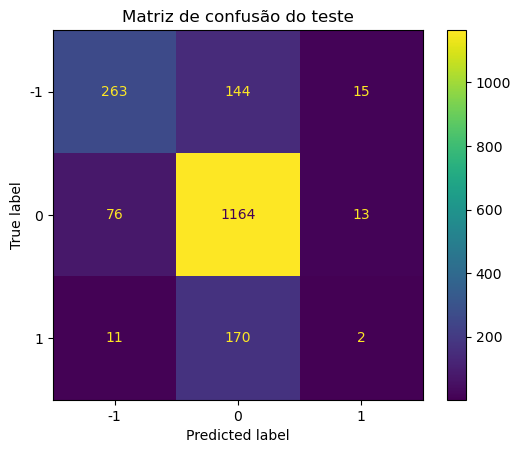

In [260]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

certos = (test_df['classe'] == test_df['Previsto']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

Certos: 772 de 1858
Accuracy: 41.55%
Classe -1:  90.04739336492891 %
Classe 0:  29.130087789305666 %
Classe 1:  14.754098360655737 %


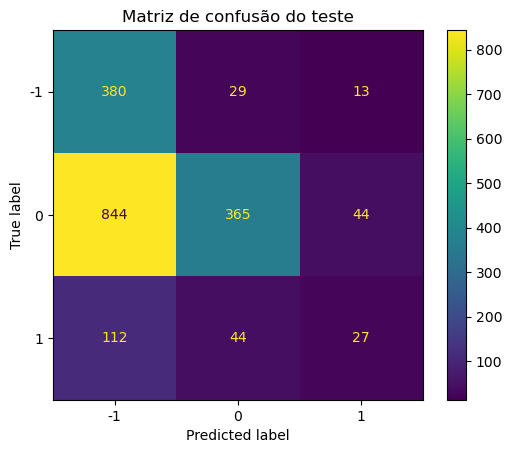

In [261]:
certos = (test_df['classe'] == test_df['Previsto2']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto2']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto2'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

Certos: 1250 de 1858
Accuracy: 67.28%
Classe -1:  0.0 %
Classe 0:  99.76057462090981 %
Classe 1:  0.0 %


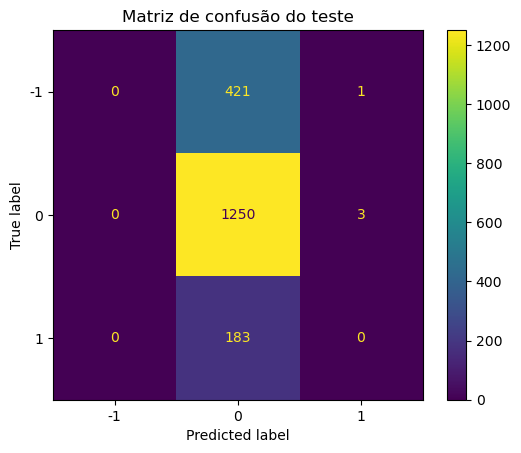

In [262]:
certos = (test_df['classe'] == test_df['Previsto3']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto3']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto3'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

Certos: 824 de 1858
Accuracy: 44.35%
Classe -1:  80.33175355450237 %
Classe 0:  31.604150039904226 %
Classe 1:  48.63387978142077 %


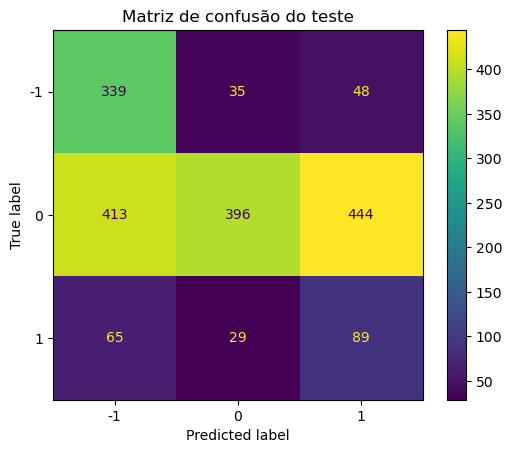

In [263]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
certos = (test_df['classe'] == test_df['Previsto4']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto4']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto4'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()